In [ ]:
# Manipulação dos dados
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import inv_boxcox

# Visualiazação dos dados
import matplotlib.pyplot as plt
import matplotlib as m

# Fonte dos dados
import yfinance as yf

# Modelos Estatíticos
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Ferramentas de dados
from datetime import date

# Modelo Prophet
from prophet import Prophet

In [2]:
plt.rcParams["figure.figsize"] = (14,6)
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [3]:
data = yf.download(tickers='ETH-USD', start = '2021-01-01', end = date.today(), interval = '1D')
dataClose = data['Close'].reset_index()
dataCloseSerie = dataClose.set_index('Date')

[*********************100%***********************]  1 of 1 completed


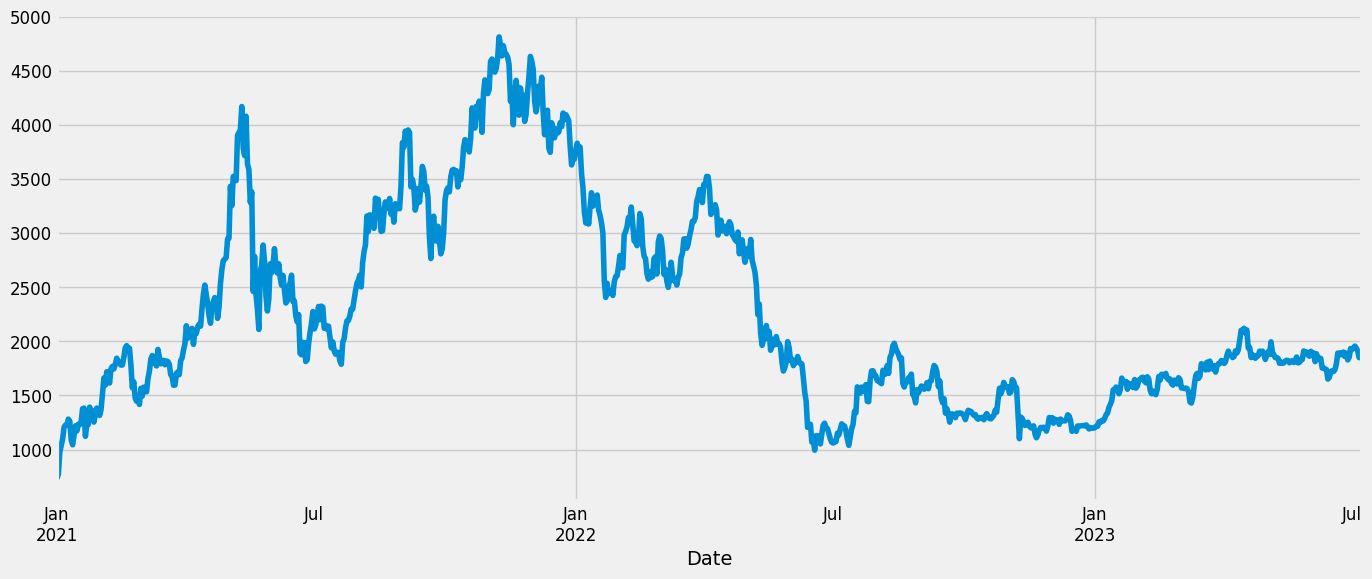

In [4]:
# Plot da Série Temporal
data.Close.plot(figsize = (15, 6))
plt.show()

In [5]:
# Definindo a função para testar serie stationarity.
def teste_estacionario(serie):
    
    # Calcular estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plotar estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Movel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado Teste Dickey-Fuller:\n')

    # Teste
    dftest = adfuller(serie, autolag = 'AIC')

    # Output
    dfout= pd.Series(dftest[0:4], index = ['Estatísticas de Teste',
                                               'p-value',
                                               'Número de Lags',
                                               'Número de Observações Utilizadas'])

    # Loop para cada output
    for key, value in dftest[4].items():
        dfout['Valor Crítico (%s)'%key] = value

    # Print
    print (dfout)
    
    # Teste p-value
    print ('\nConclusão:')
    if dfout[1] > 0.05:
        print('\nO p-value > 0.05 portanto, esta série provavelmente não é estacionária.')
    else:
        print('\nO p-value < 0.05 portanto, esta série provavelmente é estacionária.')

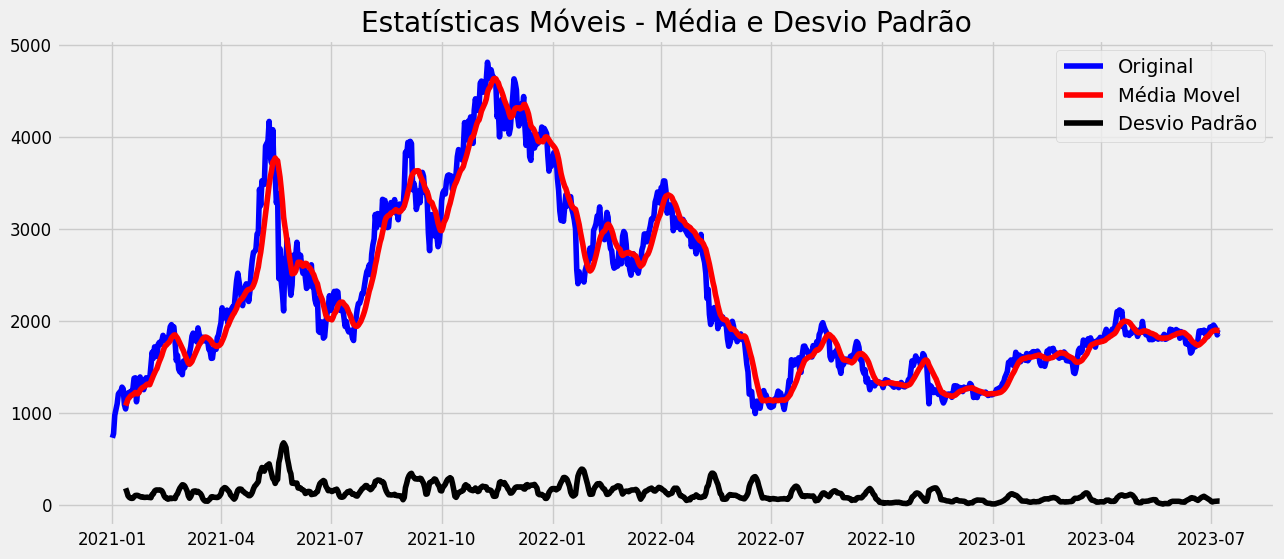


Resultado Teste Dickey-Fuller:

Estatísticas de Teste                -2.002929
p-value                               0.285290
Número de Lags                        6.000000
Número de Observações Utilizadas    912.000000
Valor Crítico (1%)                   -3.437541
Valor Crítico (5%)                   -2.864714
Valor Crítico (10%)                  -2.568460
dtype: float64

Conclusão:

O p-valuer > 0.05 portanto, esta série provavelmente não é estacionária.


In [6]:
teste_estacionario(data['Close'])

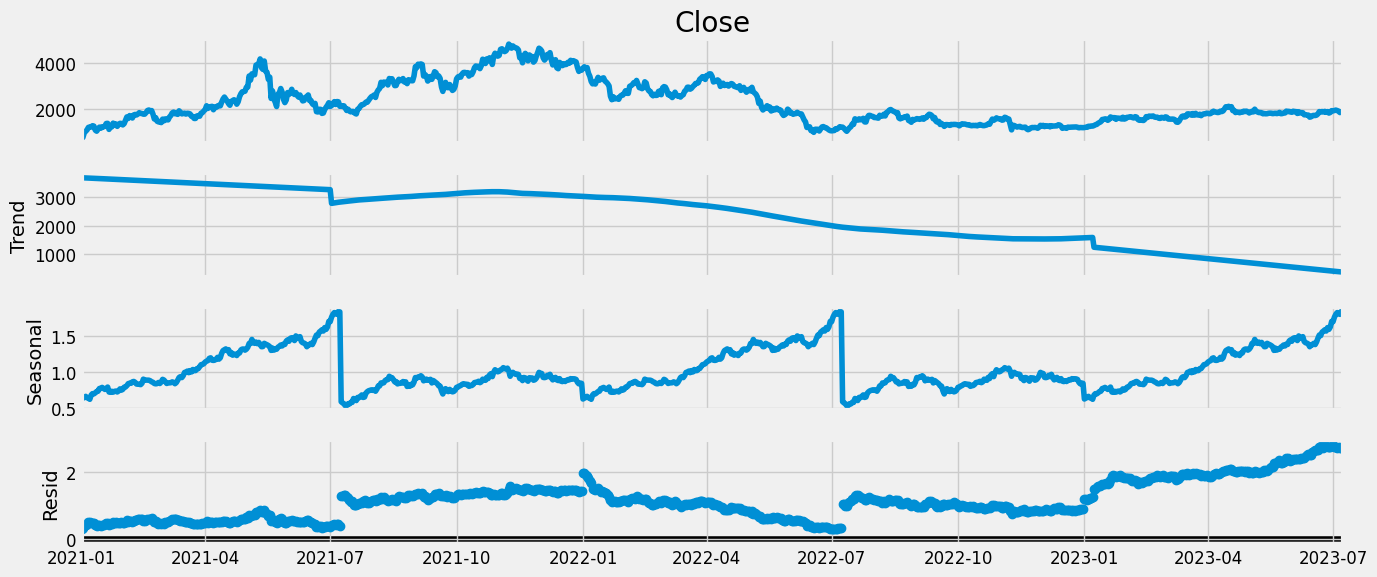

In [7]:
# Decomposição - Multiplicativa
result_mul = seasonal_decompose(data['Close'], model = 'multiplicative', period = 365, extrapolate_trend = 'freq')

# Plotar
result_mul.plot()
plt.show()

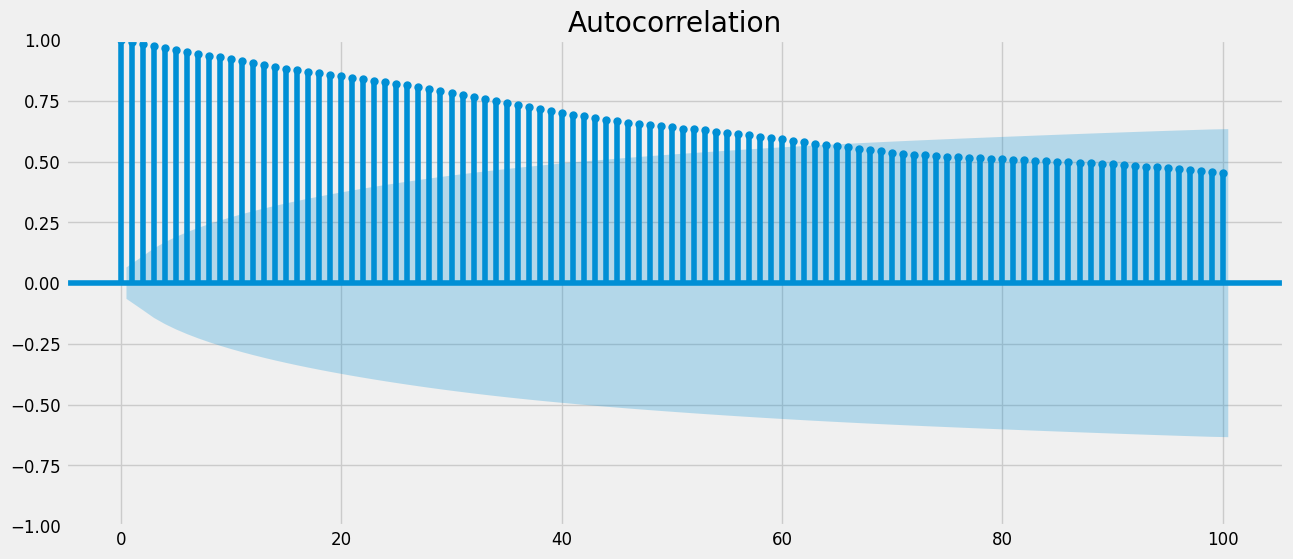

In [8]:
# Plotar gráfico de Autocorrelação 
acf_plot = plot_acf(data.Close, lags = 100)

In [9]:
#Usando Box Transformation na série pois a mesma não tem variância constante.
data['Close_Box'], lmbda = stats.boxcox(data.Close)

In [10]:
# Função de Diferenciação
def diffFunc(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff


# Inverter valor diferenciado
def inverse_difference(history, yhat):
    desdiff = list()
    for i in range(1, len(yhat)):
        valued = yhat[i] + history[i-1]
        desdiff.append(valued)
    return desdiff

In [11]:
# Diferenciação de 1ª ordem
cox_diff = diffFunc(data.Close_Box)
# Converter em um datafrme
cox_diff = pd.DataFrame(cox_diff) 

# Remover valores NA gerados
cox_diff.dropna(inplace=True)

# Preparar dados para treinamento
x = pd.Series([0])
cox_diff = pd.concat([x, cox_diff])
data.reset_index()
data = data.reset_index()
cox_diff = cox_diff.set_index(data['Date'])
data = data.set_index('Date')
data['cox_diff'] = cox_diff

In [12]:
# Precisão do modelo
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE of predictions is {}'.format(round(mse, 2))+
                  '\nRMSE of predictions is {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE of predictions is {}'.format(round(mape, 2))))

In [13]:
# Teste dividido e treino
X = data
train_size = int(len(X) * 0.80)
trainset, testset = X[0:train_size], X[train_size:]
target = trainset['cox_diff']

In [ ]:
# Modelo
model_AR = ARIMA(target, order = (2, 1, 0))

In [ ]:
# Apropriado
model_arima_fit = model_AR.fit() 

In [16]:
# Dados reais e previsões
real_data = target
pred = model_arima_fit.fittedvalues

In [ ]:
# Previsão - alfa é o intervalo de confiança - 95%
fc= model_arima_fit.forecast(len(testset), alpha = 0.05) 

# Dataframe para plotar
fc_series = pd.Series(fc, index = testset.index)

In [18]:
# Obtendo valores reais para prever
forecast = inverse_difference(testset['Close_Box'], fc_series)
forecast = inv_boxcox(forecast, lmbda)
forecast = pd.DataFrame(forecast)
forecast = pd.concat([x, forecast])
forecast.reset_index()
forecast = forecast.set_index(testset.index)

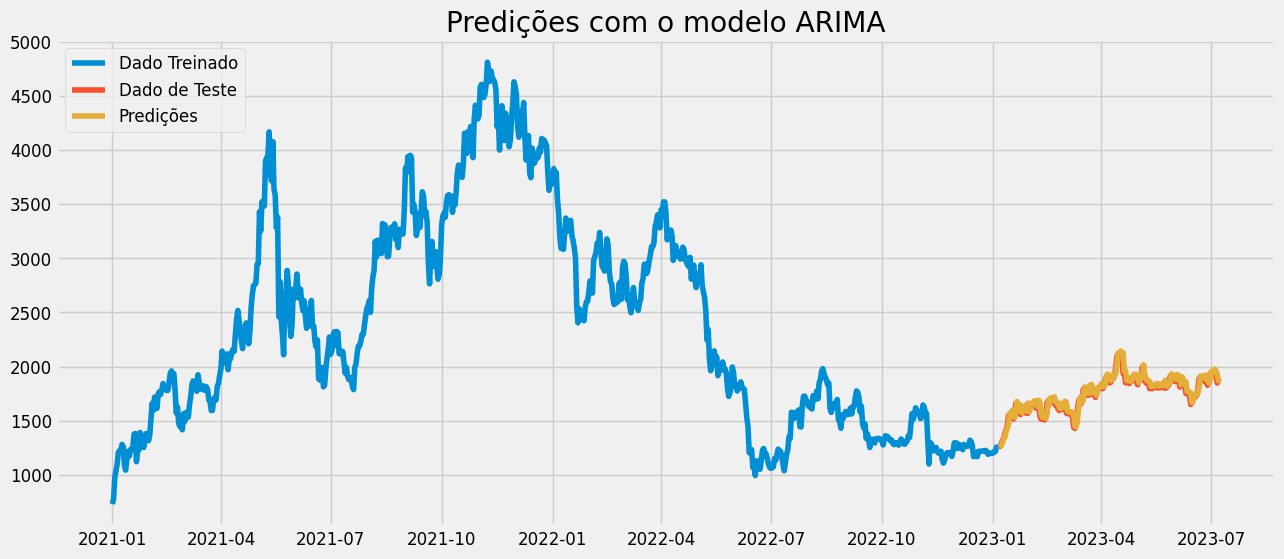

In [19]:
# Plot
plt.plot(trainset['Close'], label = 'Dado Treinado')
plt.plot(testset['Close'], label = 'Dado de Teste')
plt.plot(forecast[1:], label = 'Predições')
plt.title('Predições com o modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [20]:
# Grid Search para encontrar o melhor modelo
model_prophet = Prophet(yearly_seasonality = True)

# Formatar conjunto de dados de destino
t = data.Close.reset_index()
t = t.rename(columns = {'Date': 'ds', 'Close': 'y'})

In [21]:
# Modelo de treinamento
model_prophet.fit(t) 

11:31:26 - cmdstanpy - INFO - Chain [1] start processing
11:31:26 - cmdstanpy - INFO - Chain [1] done processing


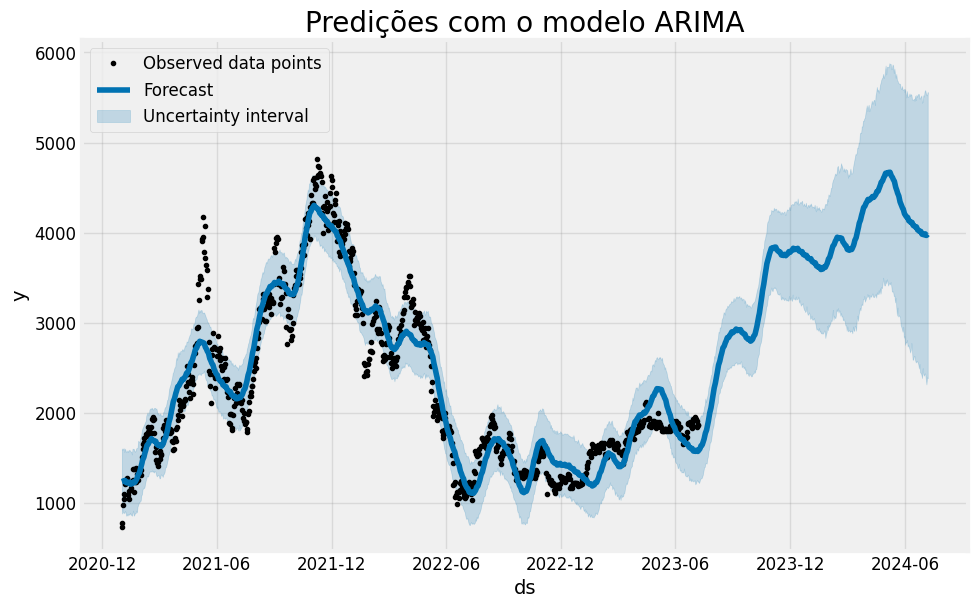

In [23]:
# Conjunto de dados para previsões
dataset_pred = model_prophet.make_future_dataframe(periods = 365, freq = 'd')

# Previsão
forecast_model_prophet = model_prophet.predict(dataset_pred)

# Plotagem da previsões
fig = model_prophet.plot(forecast_model_prophet)

plt.legend(loc = 'upper left', fontsize = 12)
plt.title('Predições com o modelo ARIMA')
plt.show()